<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Can-DL-extrapolate?" data-toc-modified-id="Can-DL-extrapolate?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Can DL extrapolate?</a></span></li><li><span><a href="#Imort-modules" data-toc-modified-id="Imort-modules-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imort modules</a></span></li><li><span><a href="#Creating-a-dummy-noisy-function" data-toc-modified-id="Creating-a-dummy-noisy-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating a dummy noisy function</a></span></li><li><span><a href="#Building-the-ANN" data-toc-modified-id="Building-the-ANN-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Building the ANN</a></span></li><li><span><a href="#Assessing-the-generalisation-of-the-model" data-toc-modified-id="Assessing-the-generalisation-of-the-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Assessing the generalisation of the model</a></span></li><li><span><a href="#Assessing-the-extrapolation-capabilities" data-toc-modified-id="Assessing-the-extrapolation-capabilities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Assessing the extrapolation capabilities</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Extrapolation with DL in KERAS

</font>
</div>

# Can DL extrapolate?

<div class="alert alert-block alert-info">
<font color=black><br>

- It is know how decision trees, random forest and SVM regressors are **unable to extrapolate**.
- There seems to be some evidence that ANNs would be capable of some extrapolation capability.
- We know extrapolation is a bad thing but if we do it with some caution it is handy.
- If the model is parametric, meaning it bares the some sort of knowledge of some parameters describing the trend, then this can be used to extrapolate.
- Just as a reminder, decision trees are **NOT** parametric.

<br></font>
</div>

# Imort modules

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 6
rcParams['font.size'] = 20

# Creating a dummy noisy function

<div class="alert alert-block alert-info">
<font color=black><br>

- In our example, we will exploit the (perhaps surprising) ability of deep neural networks (DNNs) to approximate any continuous function, provided the DNN has sufficient parameters (i.e. neurons) and training data. 
- y_p is the model prediction.
- Where the last term in function __f__ represents a randomly obtained sample from a normal distribution with zero mean and 0.2 standard deviation.
- This means the function **f** has two terms: predictable and unpredictable error.
- This last term unpredictable but it **can be modeled** through quantile regression.

<br></font>
</div>

In [2]:
def f_predictable(x):
    return x + np.sin(np.pi * x/2)

In [3]:
def f(x, std=0.2):
    # predictable + unpredictable terms
    return f_predictable(x) + np.random.randn(len(x)) * std 

In [4]:
def get_data(num, start=0, end=4):
        x = np.sort(np.random.rand(num) * (end - start) + start)
        y = f(x)
        return x.reshape(-1, 1), y

In [5]:
x_train, y_train = get_data(num=20000)
x_test, y_test = get_data(num=1000)

In [6]:
def quantile_loss(q, y_p, y):
        e = y_p - y
        return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))

# Building the ANN

<div class="alert alert-block alert-info">
<font color=black><br>

- 3 fully connected hidden layers, each with one hundred neurons.
- The last layer is linear beacause we have a regression model.
- The lambda function is used to input the quantile value to the quantile regression loss function. Keras only allows two inputs in user-defined loss functions, predictions and actual values.
- We run the code three ties to get the prediction interval for each of the test points. The reason for the choice of this values is explained later.

<br></font>
</div>

In [7]:

# The lambda function is used to input the quantile value to the quantile
# regression loss function. Keras only allows two inputs in user-defined loss
# functions, predictions and actual values.
quantiles = [0.023, 0.5, 0.977]
predictions = []
models = []
for q in quantiles:
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(100, activation='relu', input_dim=1))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss = lambda y_p, y: quantile_loss(q, y_p, y))
    model.fit(x_train, y_train, epochs = 20) 
    
    # We'll save the model the extract its extrapolation capabilities
    models.append(model)
    prediction = model.predict(x_test)
    predictions.append(prediction)          

Epoch 1/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0210
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0174
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0163
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0154
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0142
Epoch 7/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0138
Epoch 8/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0129
Epoch 9/20
625/625 [==============================] - 1s 986us/step - loss: 0.0132
Epoch 10/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0128
Epoch 11/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0126
Epoch 12/20
625/625 [==============================] - 1s 1ms/step - loss: 0.0123
Epoch 13/20
625/625 [==

In [8]:
type(prediction)

numpy.ndarray

# Assessing the generalisation of the model

<div class="alert alert-block alert-info">
<font color=black><br>

- Let's assess the model prediction within the training range.
- What we are assesing here is how well the modele generalise.
- The model training set we are using here is taken from the training population.
- In the next cell we'll see what happens when we test the model outside the training population.

<br></font>
</div>

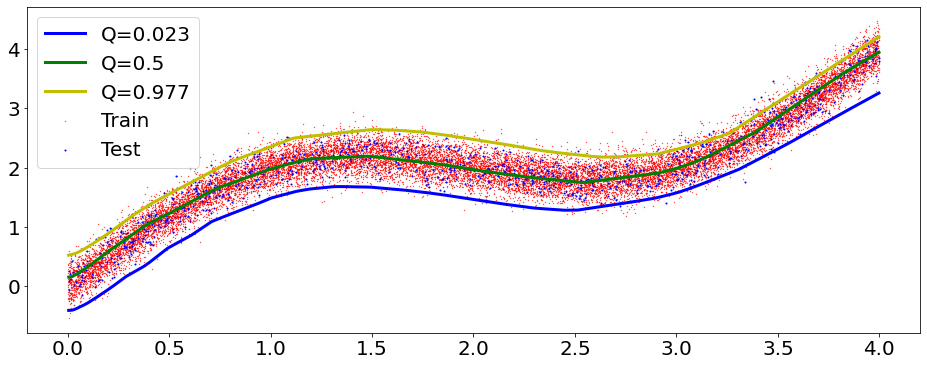

In [9]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots() 

ax.scatter(x_train, y_train, s = 0.1, c = "r", label = "Train")
ax.scatter(x_test, y_test, s = 1, c = "b", label = "Test")
colours = ["b", "g", "y"]
for i,q in enumerate(quantiles):    
    ax.plot(x_test, predictions[i], lw = 3, c = colours[i], label = "Q="+ str(q))
           
ax.legend()
plt.show()

# Assessing the extrapolation capabilities

<div class="alert alert-block alert-info">
<font color=black><br>

- At this point we'll use the model to see what happens if we want to predict in a range where the model did not train.
- This could be something like from 0.0 to 5.0, where the range from 4,0 to 5.0 has to be extrapolateed.

<br></font>
</div>

In [24]:
# This is used to test the extrapoaltion capability of the model
x_train1, y_train1 = get_data(num=20000, start = 4.0, end = 8.0)

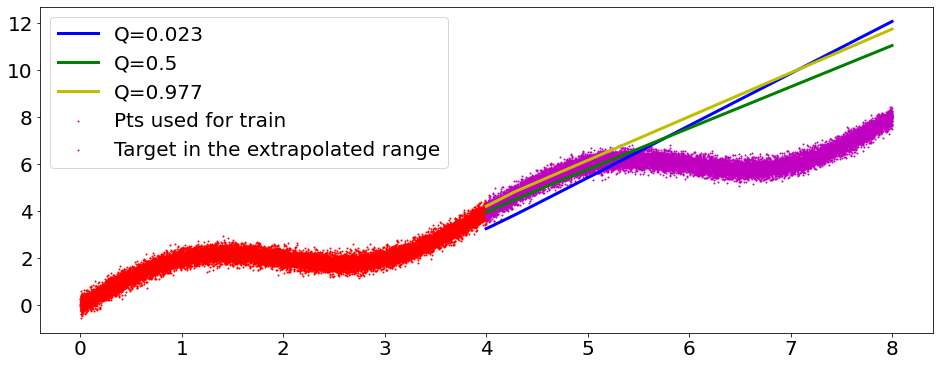

In [26]:
rcParams['figure.figsize'] = 16, 6
rcParams['font.size'] = 20
fig, ax = plt.subplots() 


ax.scatter(x_train, y_train, s = 1, c = "r", label = "Pts used for train")
ax.scatter(x_train1, y_train1, s = 1, c = "m", label = "Target in the extrapolated range")

colours = ["b", "g", "y"]
for i,q in enumerate(quantiles):        
    ax.plot(x_train1, models[i].predict(x_train1), "-", lw = 3, c = colours[i], label = "Q="+ str(q))
    
ax.legend()
plt.show()

# Conclusion

<div class="alert alert-block alert-danger">
<font color=black>

- DL have limited extrapolation capabilities.
- They are still much better than regression trees where the extrapolation would have been a straight line.
- Within some limit, I'd suggest you can still use it but be careful.

</font>
</div>

# References

<div class="alert alert-block alert-warning">
<font color=black>

- https://www.evergreeninnovations.co/blog-quantile-loss-function-for-machine-learning<br>
- https://www.wikiwand.com/en/Quantile_regression<br>

</font>
</div>